In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

## Import data

In [185]:
seed = 77

In [187]:
df = pd.read_excel("../spring21_data/fa_stats_v3.xlsx")
df = df.sample(frac=1, random_state=seed)

## Feature Cleaning

In [188]:
df = df.select_dtypes(exclude=['object'])
df.drop(columns=["Unnamed: 0", "Minutes", "salary", "clean_season", "age", "end season_y", "season_end"], inplace=True)

Split the dataset into training set, validation set, and test set (this is for the final run)

In [189]:
import smogn
from sklearn.model_selection import train_test_split

In [351]:
X = df.drop(columns=["cap_space_usage"])
y = df["cap_space_usage"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=seed)
both = pd.concat([X_train, y_train], axis=1).reset_index().drop(columns=["index"])
smote_data = smogn.smoter(data = both,
                           y = 'cap_space_usage',
                           rel_xtrm_type = 'both',
                           rel_thres = 0.95,
                           pert = 1,
                           k = 9,
                           drop_na_col = True,       ## boolean (True or False)
                           drop_na_row = True,
                           samp_method = 'extreme')
sm = smote_data.sample(frac=1, random_state = seed).reset_index(drop=True) ## make sure to shuffle the rows otherwise the cross validation will be scuffed
y = sm[['cap_space_usage']]
X = sm.drop(columns=['cap_space_usage'])

r_index: 100%|##########| 24/24 [00:00<00:00, 153.69it/s]


In [352]:
X.shape

(576, 66)

<AxesSubplot:xlabel='cap_space_usage'>

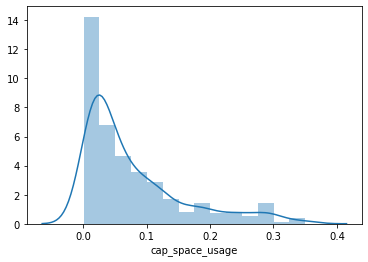

In [331]:
sns.distplot(df['cap_space_usage'])

<AxesSubplot:xlabel='cap_space_usage'>

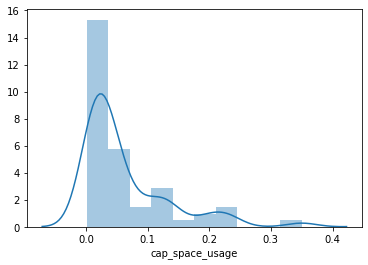

In [332]:
sns.distplot(y_test)

<AxesSubplot:xlabel='cap_space_usage'>

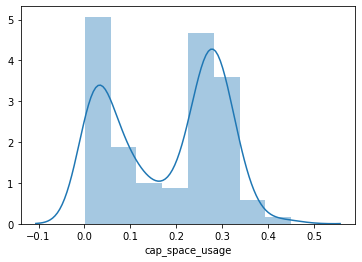

In [353]:
sns.distplot(y['cap_space_usage'])

Feature Selection

In [354]:
from sklearn.feature_selection import SelectKBest, f_regression
select = SelectKBest(f_regression, k=20)

best_features = select.fit_transform(X, y)
feature_scores = pd.concat([pd.Series(X.columns), pd.Series(select.scores_)], axis=1)
feature_scores.columns = ["features", "score"]
features = list(feature_scores.sort_values(by=["score"], ascending=False).head(10)['features'])

X = X[features]
print(len(X.columns.values))

10


/home/zach/miniconda3/envs/DataScience/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [357]:
X = X[features]
X_test = X_test[features]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=seed)

helper functions
run(model, model_name, x_train, x_val) fits the model on the training set, evaluates the fit on the training set and on the validation set.

evaluate(y_pred, y_test) prints out the evaluation metrics of a prediction.

In [250]:
def run(model, model_name, x_train, x_val):
    """ Fits the model and prints out results from calling evaluate on the training and validation set
        parameters:
            model
                the unfitted model, from sklearn (has to have a fit and predict method)
            model_name
                String, the name of the model
            x_train
                DataFrame, the training set
            x_val
                DataFrame, the validation set
                
        returns:
            nothing
        
    """
    model = model.fit(x_train, y_train)
    y_pred = np.clip(model.predict(x_train), 0, 1000) # since negative results are meaningless
    
    print("[{0}] These are the results for the training set.".format(model_name))
    
    evaluate(y_pred, y_train)
    print("--------------------------------------")
    
    print("[{0}] These are the results for the validation set.".format(model_name))
    y_pred = np.clip(model.predict(x_val), 0, 1000) # since negative results are meaningless
    
    evaluate(y_pred, y_val)
    
    print("_____________________________________________")

In [251]:
def evaluate(y_pred, y_test):
    """ Prints out the evaluation metrics of the experiment
        parameters:
            y_pred
                DataFrame or array-like, the predictions
            y_test
                DataFrame or array-like, the actual y-values
                
            these two parameters must have the same dimensions
    """
    print("r^2: ", r2_score(y_test, y_pred))
    print("mse: ", mean_squared_error(y_test, y_pred))
    print("variance_score: ", explained_variance_score(y_test, y_pred))
    print("mse-log: ", mean_squared_log_error(y_test, y_pred))

In [358]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LassoLarsCV
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_squared_log_error

lstsq = LinearRegression()
ridge = RidgeCV()
lasso = LassoCV(max_iter=5000, random_state = 0)
elasticNet = ElasticNetCV(n_alphas = 1000)
lassoLars = LassoLarsCV()

run(ridge, "Ridge", X_train, X_val)
run(lstsq, "Least Squares", X_train,  X_val)
run(lasso, "Lasso", X_train,  X_val)
run(elasticNet, "ElasticNetCV", X_train,  X_val)
run(lassoLars, "Lasso LARS", X_train,  X_val)

[Ridge] These are the results for the training set.
r^2:  0.80436141551366
mse:  0.002808050424552938
variance_score:  0.8044001426479576
mse-log:  0.002053262431786568
--------------------------------------
[Ridge] These are the results for the validation set.
r^2:  0.8211216143233373
mse:  0.0025096362592811126
variance_score:  0.821259139635492
mse-log:  0.0018207604680801092
_____________________________________________
[Least Squares] These are the results for the training set.
r^2:  0.8043504152273612
mse:  0.0028082083144635233
variance_score:  0.8043889631615904
mse-log:  0.0020534850078668724
--------------------------------------
[Least Squares] These are the results for the validation set.
r^2:  0.8210839201576879
mse:  0.0025101651026319697
variance_score:  0.8212227265036661
mse-log:  0.0018211611434243143
_____________________________________________
[Lasso] These are the results for the training set.
r^2:  0.6346061130473963
mse:  0.005244591510822078
variance_score:  0.

/home/zach/miniconda3/envs/DataScience/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/zach/miniconda3/envs/DataScience/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[ElasticNetCV] These are the results for the training set.
r^2:  0.6345106630864616
mse:  0.005245961528418709
variance_score:  0.6345984056138598
mse-log:  0.003845296655907708
--------------------------------------
[ElasticNetCV] These are the results for the validation set.
r^2:  0.6719220943961178
mse:  0.00460288259343302
variance_score:  0.6749393129083732
mse-log:  0.0034406729723553
_____________________________________________
[Lasso LARS] These are the results for the training set.
r^2:  0.8041467158346116
mse:  0.0028111320637218464
variance_score:  0.8041882604437158
mse-log:  0.0020579968643291845
--------------------------------------
[Lasso LARS] These are the results for the validation set.
r^2:  0.8220897130536177
mse:  0.0024960539828820676
variance_score:  0.82219709407006
mse-log:  0.0018134413796515917
_____________________________________________


/home/zach/miniconda3/envs/DataScience/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [359]:
evaluate(lassoLars.predict(X_test), y_test)

r^2:  0.5458224892321866
mse:  0.0022784079255921074
variance_score:  0.6035353763847863


ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.

In [360]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)

X_trainPF = poly.fit_transform(X_train)
X_valPF = poly.transform(X_val)
X_valPF = poly.transform(X_val)

lstsq = LinearRegression()
ridge = RidgeCV()
lasso = LassoCV(max_iter=50000)
elasticNet = ElasticNetCV(max_iter=50000, n_alphas = 1000)
lassoLars = LassoLarsCV()

run(ridge, "Ridge", X_trainPF, X_valPF)
run(lstsq, "Least Squares", X_trainPF, X_valPF)
run(lasso, "Lasso", X_trainPF, X_valPF)
run(elasticNet, "ElasticNetCV", X_trainPF, X_valPF)
run(lassoLars, "Lasso LARS", X_trainPF, X_valPF)

[Ridge] These are the results for the training set.
r^2:  -21.181046881096233
mse:  0.3183702145209491
variance_score:  -16.04823272444753
mse-log:  0.10000861266485223
--------------------------------------
[Ridge] These are the results for the validation set.
r^2:  -20.58283951143386
mse:  0.30280392128564537
variance_score:  -15.452560908876524
mse-log:  0.09761289466889261
_____________________________________________
[Least Squares] These are the results for the training set.
r^2:  0.8687873462003233
mse:  0.0018833286346672889
variance_score:  0.868788733595798
mse-log:  0.0013874139586321057
--------------------------------------
[Least Squares] These are the results for the validation set.
r^2:  0.8437271531816457
mse:  0.002192484023337157
variance_score:  0.8437272258418818
mse-log:  0.0016389078328766294
_____________________________________________
[Lasso] These are the results for the training set.
r^2:  0.5958680679291382
mse:  0.005800608537454527
variance_score:  0.5958

/home/zach/miniconda3/envs/DataScience/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/zach/miniconda3/envs/DataScience/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[ElasticNetCV] These are the results for the training set.
r^2:  0.595867912495926
mse:  0.005800610768427004
variance_score:  0.595867912495926
mse-log:  0.004140824208454179
--------------------------------------
[ElasticNetCV] These are the results for the validation set.
r^2:  0.6472157300027646
mse:  0.0049495090887584445
variance_score:  0.6514613111569257
mse-log:  0.003612624479614244
_____________________________________________
[Lasso LARS] These are the results for the training set.
r^2:  0.8398364755024461
mse:  0.00229886785443724
variance_score:  0.8398366239147169
mse-log:  0.0016797382068529272
--------------------------------------
[Lasso LARS] These are the results for the validation set.
r^2:  0.8457854634181139
mse:  0.0021636062470605576
variance_score:  0.8457937349520586
mse-log:  0.0016224202763285634
_____________________________________________


/home/zach/miniconda3/envs/DataScience/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [361]:
evaluate(lassoLars.predict(poly.transform(X_test)), y_test)

r^2:  0.6584503859531822
mse:  0.0017134035243436445
variance_score:  0.6730829498582125


ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.